#**Read Me**

**Do bộ dữ liệu ban đầu rất lớn và sẽ rất tốn RAM khi chạy từ đầu tới đuôi (bị tràn RAM) nên là ban đầu nhóm sẽ tiền xử lí data trên bộ gốc, sau khi mọi thứ đã xong xuôi, nhóm sẽ thực hiện lấy mẫu và tải về máy dưới dạng file csv hoặc txt. Sau đó disconnect và delete runtime để chạy lại (lần chạy này chỉ sử dụng các file tự tải về, và do dữ liệu tải về này đã tiền xử lí nên là sẽ khôgn cần phải làm lại từ đầu nữa, do đó thầy và các bạn có thể tiếp tục chạy từ phần import package và nhảy qua 2.0.1 Import data). Các bước tiền xử lí, lấy mẫu, xử lí nhãn sai sẽ được làm ở mục 1.**

# **0. Import package**

server_BCDKMAEXWSKAKFOBCSEO3O6U-UV4HD43A2T2SZH3Q

In [ ]:
# Cài link để phục vụ app
!pip install anvil-uplink

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45228 sha256=654099a904c6ba81d4f5a74fd9db5476ab2b9928aa9626f036e1cdd93db88cc4
  Stored in directory: /root/.cache/pip/wheels/2e/7c/ad/d9c746276bf024d44296340869fcb169f1e5d80fb147351a57
Successfully built ws4py


In [ ]:
# Chuyển các từ viết tắt vd như can't sang cannot
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 10.0 MB/s eta 0:00:00


In [ ]:
# Joblib để tải model về
!pip install joblib

In [ ]:
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import logging
logging.basicConfig(level=logging.ERROR)
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
import joblib

import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')

import os
from tqdm import tqdm
import time
import anvil.server

anvil.server.connect('server_BCDKMAEXWSKAKFOBCSEO3O6U-UV4HD43A2T2SZH3Q')
torch.manual_seed(1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


**Để tránh mất thời gian và dung lượng thì mọi người nên chạy tiếp từ mục 2.0.1**

In [ ]:
# Data train
#https://drive.google.com/file/d/1ZWnEccAMmKl9JGLjbr39e9AUHn0_r4e_/view?usp=sharing
!gdown 1ZWnEccAMmKl9JGLjbr39e9AUHn0_r4e_

Downloading...
From: https://drive.google.com/uc?id=1ZWnEccAMmKl9JGLjbr39e9AUHn0_r4e_
To: /content/train.ft.txt
100% 1.60G/1.60G [00:22<00:00, 69.8MB/s]


In [ ]:
# Path tới tập train
file_path_train = '/content/train.ft.txt'

# Đọc content tập train
with open(file_path_train, 'r') as file:
    content_train = file.readlines()

In [ ]:
# Data test
#https://drive.google.com/file/d/1vrM3twfe387IEPPwTF3fSv-CGSSwZf66/view?usp=sharing
!gdown 1vrM3twfe387IEPPwTF3fSv-CGSSwZf66

Downloading...
From: https://drive.google.com/uc?id=1vrM3twfe387IEPPwTF3fSv-CGSSwZf66
To: /content/test.ft.txt
100% 177M/177M [00:03<00:00, 50.8MB/s]


In [ ]:
# Path tới tập test
file_path_test = '/content/test.ft.txt'

# Đọc content tập test
with open(file_path_test, 'r') as file:
    content_test = file.readlines()

# **1. Chuẩn bị và tiền xử lí data**

## 1.1 Load dữ liệu.

In [ ]:
# Cho dữ liệu train_content vào trong DataFrame
data = {'text': [], 'label': []}

for line in content_train:
    if line.startswith('__label__1'):
        label = 0
        text = line.replace('__label__1', '').strip()
        data['text'].append(text)
        data['label'].append(label)
    elif line.startswith('__label__2'):
        label = 1
        text = line.replace('__label__2', '').strip()
        data['text'].append(text)
        data['label'].append(label)

In [ ]:
# Cho dữ liệu test_content vào trong DataFrame
data_test = {'text': [], 'label': []}

for line in content_test:
    if line.startswith('__label__1'):
        label = 0
        text = line.replace('__label__1', '').strip()
        data_test['text'].append(text)
        data_test['label'].append(label)
    elif line.startswith('__label__2'):
        label = 1
        text = line.replace('__label__2', '').strip()
        data_test['text'].append(text)
        data_test['label'].append(label)

In [ ]:
df = pd.DataFrame(data)
df = df[['text', 'label']]

# Display
df.head()

,text,label
0,Stuning even for the non-gamer: This sound tra...,1
1,The best soundtrack ever to anything.: I'm rea...,1
2,Amazing!: This soundtrack is my favorite music...,1
3,Excellent Soundtrack: I truly like this soundt...,1
4,"Remember, Pull Your Jaw Off The Floor After He...",1


In [ ]:
test_df = pd.DataFrame(data_test)
test_df = test_df[['text', 'label']]

# Display
test_df.head()

,text,label
0,Great CD: My lovely Pat has one of the GREAT v...,1
1,One of the best game music soundtracks - for a...,1
2,Batteries died within a year ...: I bought thi...,0
3,"works fine, but Maha Energy is better: Check o...",1
4,Great for the non-audiophile: Reviewed quite a...,1


In [ ]:
print(f'len of the train data is {len(df)}')
print(f'len of the test data is {len(test_df)}')
# Quá lớn -> Phải reduce

len of the train data is 3600000
len of the test data is 400000


In [ ]:
# Chọn mẫu ngẫu nhiên
df_sampled = pd.concat([df[df['label'] == 0].sample(n = 20000, random_state=1),
                       df[df['label'] == 1].sample(n = 20000, random_state=1)])
df_sampled = df_sampled[['text', 'label']]
df_sampled.reset_index(drop=True, inplace=True)

# Sau khi trích mẫu
print(f'len of the train data is {len(df_sampled)}')
df_sampled

len of the train data is 40000


,text,label
0,"2.5 stars beats hot, lyrics horrendous: The go...",0
1,Hurt my neck and Brookstone wouldn't accept re...,0
2,Not the LP version: An ok cd but it's not the ...,0
3,"Not good, just bad and ugly.: This is the wors...",0
4,20lbs really means 5lbs: I had a choice betwee...,0
...,...,...
39995,Exceeded My Expectations: I am so very happy w...,1
39996,:(: I thought the way the story was written wa...,1
39997,The best all-audio learning method: One might ...,1
39998,Archos 604 Wifi 30GB portable multimedia: This...,1


In [ ]:
test_df = pd.concat([test_df[test_df['label'] == 0].sample(n = 500 , random_state=1),
                       test_df[test_df['label'] == 1].sample(n= 500, random_state=1)])
test_df = test_df[['text', 'label']]
test_df.reset_index(drop=True, inplace=True)
# Sau khi trích mẫu
print(f'len of the test data is {len(test_df)}')
test_df

len of the test data is 1000


,text,label
0,"Man, this is sick stuff!!!!: I set out on a mi...",0
1,Still waiting for hardware: Ordered (1) chair ...,0
2,"OK Idea, Poorly Executed: Julia was good. Brad...",0
3,Don't bother: This is a total waste of paper. ...,0
4,"Good, but disappointing: This was a good movie...",0
...,...,...
995,no problemo: Our school has 100 of the LaCie P...,1
996,Thank you Decapitated!: This album ironically ...,1
997,Super item!: This vest came in handy for a my ...,1
998,Great for the price: The car charger works as ...,1


In [ ]:
# Tạo tập train và tập test
train_df, val_df = train_test_split(df_sampled, test_size=0.05, random_state=1, stratify=df_sampled['label'])
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

# Display
print("Training Set:")
print(train_df.head())

# Display
print("\nValidation Set:")
print(val_df.head())

# Display
print("\nTest Set:")
print(test_df.head())


Training Set:
                                                text  label
0  dare you to finish this book: I dare you to fi...      0
1  Amazon should not be promoting "hate" stuff li...      0
2  Herbie plays it easy-listening: As an HH great...      0
3  Freddie Will Live 4Ever: As long as there are ...      1
4  Cord description 100% incorrect: New in origin...      0

Validation Set:
                                                text  label
0  Pen cracked: The black pen cracked when screwi...      0
1  george does what it does best help other's: ge...      1
2  Good Hand Exercise Unit: This Gripmaster is he...      1
3  Over-Engineered: Bought this a year ago and qu...      0
4  Totally riveting!: I have read many other book...      1

Test Set:
                                                text  label
0  Man, this is sick stuff!!!!: I set out on a mi...      0
1  Still waiting for hardware: Ordered (1) chair ...      0
2  OK Idea, Poorly Executed: Julia was good. Brad...      

## 1.2 Tiền xử lí dữ liệu.

In [ ]:
import re
from contractions import contractions_dict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess_text(text):
    # Bỏ URLs
    url_pattern = re.compile(r'https?://\S+')
    text = url_pattern.sub(' ', text)

    # Bỏ HTML Tags
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(' ', text)

    # Mở rộng contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Bỏ punctuation và digits
    text = re.sub(r'[^\w\s]', ' ', text)

    # Bỏ emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U0001F1F2-\U0001F1F4"
        u"\U0001F1E6-\U0001F1FF"
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(' ', text)

    # Chuyển sang viết thường
    text = text.lower()

    # Tokenize và bỏ  stopwords
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]

    # Nối các token thành text
    text = ' '.join(tokens)

    return text


# **2. Mô hình**

##2.0  Loại bỏ gánh nặng

In [ ]:
df_sampled = pd.concat([train_df, val_df], axis=0)
df_sampled = df_sampled.reset_index(drop=True)
df_sampled

,text,label
0,dare you to finish this book: I dare you to fi...,0
1,"Amazon should not be promoting ""hate"" stuff li...",0
2,Herbie plays it easy-listening: As an HH great...,0
3,Freddie Will Live 4Ever: As long as there are ...,1
4,Cord description 100% incorrect: New in origin...,0
...,...,...
39995,Powdered wax is a bad idea: My daughter receiv...,0
39996,WHAT was the Network Thinking??: Answer...they...,1
39997,After Shave Cream: This product is a great fol...,1
39998,Zzzzzzzzzzzzzzzzzzzz: I thought I was gonna fa...,0


In [ ]:
df_sampled['preprocess_sentence'] = df_sampled['text'].apply(preprocess_text)

In [ ]:
X, y = df_sampled.preprocess_sentence, df_sampled.label

# Đặt threshold
confidence_threshold = 0.95 #1. 95%, 2. 80%

# K-Fold
kfold = KFold(n_splits=5, shuffle=False)

In [ ]:
# Mảng chứa sample đúng
corrected_test_sets = []

# Lặp qua từng Fold
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Tạo classifier
    model = make_pipeline(TfidfVectorizer(), MultinomialNB())
    model.fit(X_train, y_train)

    # Lấy giá trị dự đoán cho mỗi sample
    probabilities = model.predict_proba(X_test)

    # Xác định mẫu có khả năng sai nhãn
    misclassified_indices = np.where((np.max(probabilities, axis=1) > confidence_threshold) & (y_test != np.max(probabilities, axis=1)))[0]

    # Bỏ mẫu đó ra khỏi tập test
    X_test_corrected = X_test.drop(X_test.index[misclassified_indices])
    y_test_corrected = y_test.drop(y_test.index[misclassified_indices])

    # Lưu lại tập test mới
    corrected_test_sets.append((X_test_corrected, y_test_corrected))

In [ ]:
df_new_train = pd.concat([pd.DataFrame({'text': X_test_corrected.tolist(), 'label': y_test_corrected.tolist()}) for X_test_corrected, y_test_corrected in corrected_test_sets], axis=0, ignore_index=True)

In [ ]:
df_new_train

,text,label
0,dare finish book dare finish book simple inter...,0
1,amazon promoting hate stuff like hate jews hom...,0
2,herbie plays easy listening hh great fan disap...,0
3,freddie live 4ever long humans electricity con...,1
4,cord description 100 incorrect new original pa...,0
...,...,...
39429,powdered wax bad idea daughter received one tw...,0
39430,network thinking answer terrific show yanked 4...,1
39431,shave cream product great follow close shave v...,1
39432,zzzzzzzzzzzzzzzzzzzz thought going fall asleep...,0


In [ ]:
# Lưu
df_new_train.to_csv('train.csv', index=False)

In [ ]:
# Lưu
test_df.to_csv('test.csv', index = False)

In [ ]:
test_df

,text,label
0,"Man, this is sick stuff!!!!: I set out on a mi...",0
1,Still waiting for hardware: Ordered (1) chair ...,0
2,"OK Idea, Poorly Executed: Julia was good. Brad...",0
3,Don't bother: This is a total waste of paper. ...,0
4,"Good, but disappointing: This was a good movie...",0
...,...,...
995,no problemo: Our school has 100 of the LaCie P...,1
996,Thank you Decapitated!: This album ironically ...,1
997,Super item!: This vest came in handy for a my ...,1
998,Great for the price: The car charger works as ...,1


## 2.0.1 Import data

**Mọi người có thể bắt đầu chạy từ cell dưới đây**

Cài lại hàm preprocess do sau này còn sử dụng.

In [ ]:
import re
from contractions import contractions_dict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess_text(text):
    # Bỏ URLs
    url_pattern = re.compile(r'https?://\S+')
    text = url_pattern.sub(' ', text)

    # Bỏ HTML Tags
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(' ', text)

    # Mở rộng contractions
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])

    # Bỏ punctuation và digits
    text = re.sub(r'[^\w\s]', ' ', text)

    # Bỏ emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U0001F1F2-\U0001F1F4"
        u"\U0001F1E6-\U0001F1FF"
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(' ', text)

    # Chuyển sang viết thường
    text = text.lower()

    # Tokenize và bỏ  stopwords
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]

    # Nối các token thành text
    text = ' '.join(tokens)

    return text


In [ ]:
# Download data đã rút bớt và loại bỏ các sample có nhãn xấu
#https://drive.google.com/file/d/1hBe4AYtWY00gbzPBOSOERNkM5rbz2tPM/view?usp=sharing
!gdown --id 1hBe4AYtWY00gbzPBOSOERNkM5rbz2tPM

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1hBe4AYtWY00gbzPBOSOERNkM5rbz2tPM
To: /content/data.zip
100% 4.51M/4.51M [00:00<00:00, 60.2MB/s]


In [ ]:
!unzip -q /content/data.zip

In [ ]:
data = pd.read_csv('./data/train.csv')
#train_df['preprocess_sentence'] = [preprocess_text(row['text']) for index, row in train_df.iterrows()]

In [ ]:
data

,text,label
0,dare finish book dare finish book simple inter...,0
1,amazon promoting hate stuff like hate jews hom...,0
2,herbie plays easy listening hh great fan disap...,0
3,freddie live 4ever long humans electricity con...,1
4,cord description 100 incorrect new original pa...,0
...,...,...
39429,powdered wax bad idea daughter received one tw...,0
39430,network thinking answer terrific show yanked 4...,1
39431,shave cream product great follow close shave v...,1
39432,zzzzzzzzzzzzzzzzzzzz thought going fall asleep...,0


In [ ]:
test_df = pd.read_csv('./data/test.csv')

In [ ]:
test_df

,text,label,preprocess_sentence
0,"Man, this is sick stuff!!!!: I set out on a mi...",0,man sick stuff set mission seek shocking films...
1,Still waiting for hardware: Ordered (1) chair ...,0,still waiting hardware ordered 1 chair 1 loves...
2,"OK Idea, Poorly Executed: Julia was good. Brad...",0,ok idea poorly executed julia good brad usual ...
3,Don't bother: This is a total waste of paper. ...,0,bother total waste paper save forrest print bo...
4,"Good, but disappointing: This was a good movie...",0,good disappointing good movie general however ...
...,...,...,...
995,no problemo: Our school has 100 of the LaCie P...,1,problemo school 100 lacie p3 xp never problem ...
996,Thank you Decapitated!: This album ironically ...,1,thank decapitated album ironically makes hope ...
997,Super item!: This vest came in handy for a my ...,1,super item vest came handy son birthday party ...
998,Great for the price: The car charger works as ...,1,great price car charger works expected ear bud...


##2.0.2 EDA data

**Kiểm tra distribution của các nhãn**

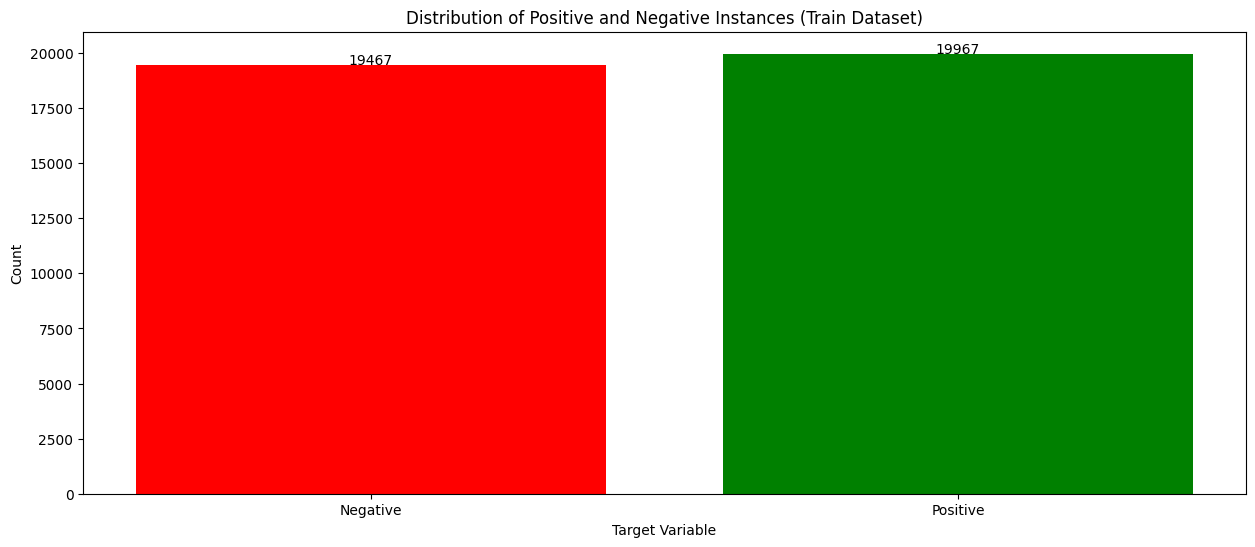

In [ ]:
positive_count = data['label'].sum()
negative_count = len(data) - positive_count

# Tạo bar chart
plt.figure(figsize=(15, 6))
plt.bar(['Negative', 'Positive'], [negative_count, positive_count], color=['red', 'green'])
plt.title('Distribution of Positive and Negative Instances (Train Dataset)')
plt.xlabel('Target Variable')
plt.ylabel('Count')

for i, count in enumerate([negative_count, positive_count]):
    plt.text(i, count + 0.1, str(count), ha='center')

plt.show()

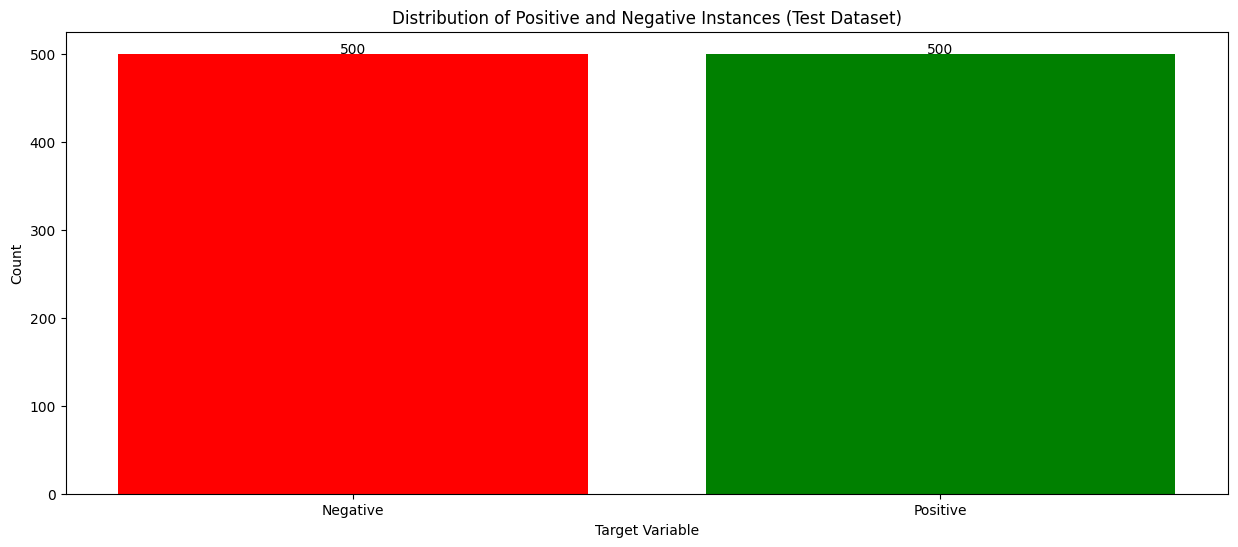

In [ ]:
positive_count_test = test_df['label'].sum()
negative_count_test = len(test_df) - positive_count_test

plt.figure(figsize=(15, 6))
plt.bar(['Negative', 'Positive'], [negative_count_test, positive_count_test], color=['red', 'green'])
plt.title('Distribution of Positive and Negative Instances (Test Dataset)')
plt.xlabel('Target Variable')
plt.ylabel('Count')

for i, count in enumerate([negative_count_test, positive_count_test]):
    plt.text(i, count + 0.1, str(count), ha='center')

plt.show()

**Kiểm tra độ dài chuỗi**

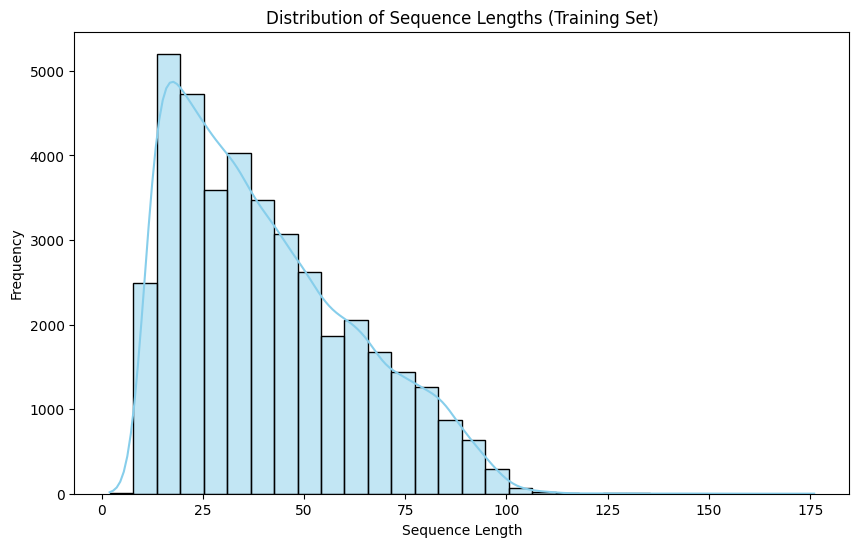

In [ ]:
sequence_lengths_train = data['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(sequence_lengths_train, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Sequence Lengths (Training Set)')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

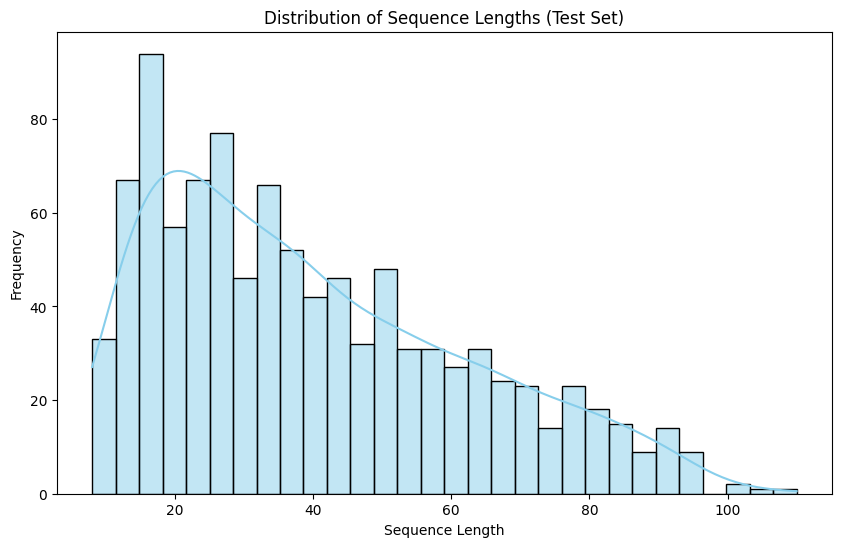

In [ ]:
sequence_lengths_train = test_df['preprocess_sentence'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(sequence_lengths_train, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Sequence Lengths (Test Set)')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

## 2.1 Mô hình ML truyền thống.

In [ ]:
# Chia tập train và tập test
train_df, val_df = train_test_split(data, test_size=0.05, random_state=1)
# Hiển thị shape
print("New Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)

New Training set shape: (37462, 2)
Validation set shape: (1972, 2)


In [ ]:
X_train = train_df['text']
y_train = train_df['label']
X_test = test_df['text']
y_test = test_df['label']
X_val = val_df['text']
y_val = val_df['label']

**Các siêu tham số đã chọn ra từ quá trình tinh chỉnh**

In [ ]:
# Cài đặt Pipeline với tham số chọn từ GridSearch
model_NB = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=1, ngram_range=(1, 2))),
    ('nb', MultinomialNB())
])

# Huấn luyện mô hình trên tập huấn luyện
model_NB.fit(X_train, y_train)

# Dự đoán nhãn trên tập kiểm thử
y_pred = model_NB.predict(X_test)
predicted_probabilities = model_NB.predict_proba(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

Accuracy: 0.843
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       500
           1       0.85      0.84      0.84       500

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



In [ ]:
# Check model
model_NB

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('nb', MultinomialNB())])

In [ ]:
# Tải model về để phục vụ cho ném lên huggingfaces spaces
filename = 'model_NB.sav'
joblib.dump(model_NB, filename)

['model_NB.sav']

**Cụ thể quá trình tinh chỉnh siêu tham số**


In [ ]:
# Lưới tham số
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__min_df': [1, 2, 3],
    'nb__alpha': [0.1, 0.5, 1.0],
}

# Tạo pipeline
model_NB = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Tuning
grid_search = GridSearchCV(model_NB, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Chọn tham số tốt nhất
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

model_NB = grid_search.best_estimator_

# Dự đoán nhãn trên tập kiểm thử
y_pred = model_NB.predict(X_test)
predicted_probabilities = model_NB.predict_proba(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)


Best Hyperparameters: {'nb__alpha': 1.0, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Accuracy: 0.843
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       500
           1       0.85      0.84      0.84       500

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



## 2.2 Mô hình MaxEnt.

**Các siêu tham số đã chọn ra từ quá trình tinh chỉnh**

In [ ]:
# Các siêu tham số
best_parameters = {'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 2)}

# Cài đặt Pipeline với tham số chọn từ GridSearch

model_LR = Pipeline([
    ('tfidfvectorizer', TfidfVectorizer(ngram_range=best_parameters['tfidfvectorizer__ngram_range'])),
    ('logisticregression', LogisticRegression(C=best_parameters['logisticregression__C']))
])

# Huấn luyện mô hình trên tập huấn luyện
model_LR.fit(X_train, y_train)

# Dự đoán nhãn trên tập kiểm thử
y_pred = model_LR.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.881
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       500
           1       0.87      0.90      0.88       500

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



In [ ]:
# Tải model về để phục vụ cho ném lên huggingfaces spaces
filename = 'model_LR.sav'
joblib.dump(model_LR, filename)

['model_LR.sav']

**Cụ thể quá trình tinh chỉnh siêu tham số**


In [ ]:
# Tạo lưới tham số
param_grid = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'logisticregression__C': [1, 10, 100]
}
# Tạo pipeline
model_LR = make_pipeline(TfidfVectorizer(), LogisticRegression())
grid_search = GridSearchCV(model_LR, param_grid, cv=5, scoring='accuracy')

# Fit lưới
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
model_LR = grid_search.best_estimator_
y_pred = model_LR.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best Parameters: {'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 2)}
Accuracy: 0.881
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       500
           1       0.87      0.90      0.88       500

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 2.3 Mô hình Deep Learning

**Chạy từ mục 2.3.1 tới hết mục 2.3.3, ở mục 2.3.4 có đoạn code bắt mình train lại từ đầu (tốn thời gian và dung lượng) nên ngay phía dưới đoạn code đó có đoạn !gdown sẽ tải model weight từ google drive của nhóm về colab này**

### 2.3.1 Chuẩn bị.

In [ ]:
!pip install -q torchtext==0.16.0

In [ ]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [ ]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

In [ ]:
tokenizer

<function torchtext.data.utils._basic_english_normalize(line)>

In [ ]:
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df['text'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [ ]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    for index, row in df.iterrows():
        sentence = row['text']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df)
train_dataset = to_map_style_dataset(train_dataset)
val_dataset = prepare_dataset(val_df)
val_dataset = to_map_style_dataset(val_dataset)
test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

In [ ]:
import torch

seq_length = 100

def collate_batch(batch):
    sentences, labels = list(zip(*batch))
    encoded_sentences = [
        sentence+([0]* (seq_length-len(sentence))) if len(sentence) < seq_length else sentence[:seq_length]
        for sentence in sentences
    ]

    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)

    return encoded_sentences, labels

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

### 2.3.2 Xây dựng hàm train và test

In [ ]:

import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        loss = criterion(predictions, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [ ]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

### 2.3.3 Xây dựng mô hình Transformer(Encoder)

####Token and Positional Embedding

In [ ]:
class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, device='cpu'):
        super().__init__()
        self.device = device
        self.word_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )
        self.pos_emb = nn.Embedding(
            num_embeddings=max_length,
            embedding_dim=embed_dim
        )

    def forward(self, x):
        N, seq_len = x.size()
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        output1 = self.word_emb(x)
        output2 = self.pos_emb(positions)
        output = output1 + output2
        return output

In [ ]:
vocab_size = 10000
embed_dim = 200
max_length = 50
embedding = TokenAndPositionEmbedding(
    vocab_size,
    embed_dim,
    max_length
)

####Transformer-Encoder Layer

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2

In [ ]:
encoder_layer = TransformerEncoder(
    embed_dim=200,
    num_heads=5,
    ff_dim=1024
)

In [ ]:
class TransformerEncoderCls(nn.Module):
    def __init__(self,
                 vocab_size, max_length, embed_dim, num_heads, ff_dim,
                 dropout=0.1, device='cpu'
        ):
        super().__init__()
        self.embd_layer = TokenAndPositionEmbedding(
            vocab_size, embed_dim, max_length, device
        )
        self.transformer_layer = TransformerEncoder(
            embed_dim, num_heads, ff_dim, dropout
        )
        self.pooling = nn.AvgPool1d(kernel_size=max_length)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=2)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
    def forward(self, x):
        output = self.embd_layer(x)
        output = self.transformer_layer(output, output, output)
        output = self.pooling(output.permute(0,2,1)).squeeze()
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

In [ ]:
vocab_size = 10000
max_length = 100
embed_dim = 200
num_heads = 4
ff_dim = 128
dropout=0.1
model = TransformerEncoderCls(
    vocab_size, max_length, embed_dim, num_heads, ff_dim, dropout
)

In [ ]:
x = 'this is a demo sentence'
x = vocabulary(tokenizer(x))
input =  x+([0]* (max_length-len(x))) if len(x) < max_length else x[:max_length]
# Chuyển sang tensor và thêm chiều batch
input_tensor = torch.tensor(input).unsqueeze(0)

print("Processed Input:", input_tensor)
model(input_tensor)

Processed Input: tensor([[   1,    1,    1, 4734, 2666,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]])


tensor([-0.4013, -0.0074], grad_fn=<ViewBackward0>)

### 2.3.4 Huấn luyện mô hình

**Code cho bước huấn luyện mô hình, nhưng do nó chạy lâu nên là mọi người cứ kéo xuống cái file có cái !gdown cách dưới 2 cell**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerEncoderCls(
    vocab_size, max_length, embed_dim, num_heads, ff_dim, dropout, device
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 15
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'model_TC'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device
)

save_path = os.path.join(save_model, f"{model_name}.pt")
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

| epoch   1 |    50/  293 batches | accuracy    0.506
| epoch   1 |   100/  293 batches | accuracy    0.518
| epoch   1 |   150/  293 batches | accuracy    0.540
| epoch   1 |   200/  293 batches | accuracy    0.606
| epoch   1 |   250/  293 batches | accuracy    0.648
-----------------------------------------------------------
| End of epoch   1 | Time: 217.99s | Train Accuracy    0.682 | Train Loss    0.667 | Valid Accuracy    0.704 | Valid Loss    0.571 
-----------------------------------------------------------
| epoch   2 |    50/  293 batches | accuracy    0.711
| epoch   2 |   100/  293 batches | accuracy    0.723
| epoch   2 |   150/  293 batches | accuracy    0.745
| epoch   2 |   200/  293 batches | accuracy    0.749
| epoch   2 |   250/  293 batches | accuracy    0.767
-----------------------------------------------------------
| End of epoch   2 | Time: 195.35s | Train Accuracy    0.771 | Train Loss    0.524 | Valid Accuracy    0.769 | Valid Loss    0.465 
----------------

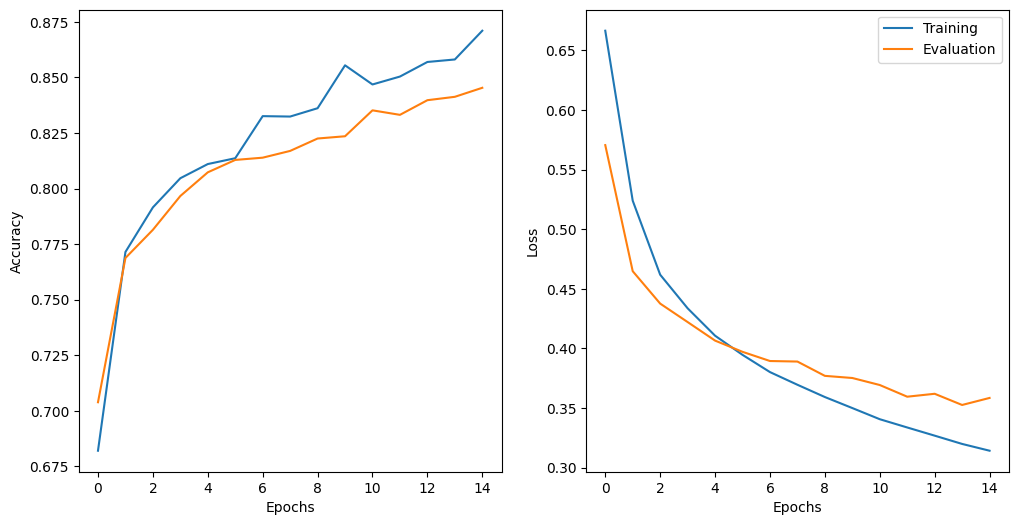

In [ ]:
plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

**Chạy tiếp đoạn sau**

In [ ]:
#https://drive.google.com/file/d/14cIS6zkIivM_Q0gJjL8ZHagVi9rKJ_DD/view?usp=sharing
!gdown --id 14cIS6zkIivM_Q0gJjL8ZHagVi9rKJ_DD

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=14cIS6zkIivM_Q0gJjL8ZHagVi9rKJ_DD
To: /content/model_TC.pt
100% 8.96M/8.96M [00:00<00:00, 50.2MB/s]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load mô hình
model_TC = TransformerEncoderCls(
    vocab_size, max_length, embed_dim, num_heads, ff_dim, dropout, device
)
model_TC.to(device)

loaded_model_path = 'model_TC.pt'
model_TC.load_state_dict(torch.load(loaded_model_path))

<All keys matched successfully>

In [ ]:
model_TC

TransformerEncoderCls(
  (embd_layer): TokenAndPositionEmbedding(
    (word_emb): Embedding(10000, 200)
    (pos_emb): Embedding(100, 200)
  )
  (transformer_layer): TransformerEncoder(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
    )
    (ffn): Sequential(
      (0): Linear(in_features=200, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=200, bias=True)
    )
    (layernorm_1): LayerNorm((200,), eps=1e-06, elementwise_affine=True)
    (layernorm_2): LayerNorm((200,), eps=1e-06, elementwise_affine=True)
    (dropout_1): Dropout(p=0.1, inplace=False)
    (dropout_2): Dropout(p=0.1, inplace=False)
  )
  (pooling): AvgPool1d(kernel_size=(100,), stride=(100,), padding=(0,))
  (fc1): Linear(in_features=200, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
)

In [ ]:
# Tải model về để phục vụ cho ném lên huggingfaces spaces
filename = 'model_TC.sav'
joblib.dump(model_TC, filename)

['model_TC.sav']

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# Check for accuracy
test_acc, test_loss = evaluate_epoch(model_TC, criterion, test_dataloader, device)
test_acc, test_loss

(0.749, 0.5637584440410137)

###2.3.5 Phân loại bằng phân cụm

In [ ]:
# Lấy tới lớp pooling
class PartialModelWithPooling(nn.Module):
    def __init__(self, original_model):
        super(PartialModelWithPooling, self).__init__()

        # Copy layers from the original model up to and including the pooling layer
        self.embd_layer = original_model.embd_layer
        self.transformer_layer = original_model.transformer_layer
        self.pooling = original_model.pooling
        self.fc1 = nn.Linear(original_model.fc1.in_features, original_model.fc1.out_features)
        self.fc2 = nn.Linear(original_model.fc2.in_features, original_model.fc2.out_features)
        self.dropout = original_model.dropout
        self.relu = original_model.relu

        # Initialize new linear layers with the weights from the original model
        self.fc1.weight.data = original_model.fc1.weight.data
        self.fc1.bias.data = original_model.fc1.bias.data
        self.fc2.weight.data = original_model.fc2.weight.data
        self.fc2.bias.data = original_model.fc2.bias.data

    def forward(self, x):
        # Forward pass through the layers up to and including the pooling layer
        output = self.embd_layer(x)
        output = self.transformer_layer(output, output, output)
        output = self.pooling(output.permute(0, 2, 1)).squeeze()
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

# Tạo mô hình mới
model_optics = PartialModelWithPooling(model_TC)

In [ ]:
test_df

,text,label,preprocess_sentence
0,"Man, this is sick stuff!!!!: I set out on a mi...",0,man sick stuff set mission seek shocking films...
1,Still waiting for hardware: Ordered (1) chair ...,0,still waiting hardware ordered 1 chair 1 loves...
2,"OK Idea, Poorly Executed: Julia was good. Brad...",0,ok idea poorly executed julia good brad usual ...
3,Don't bother: This is a total waste of paper. ...,0,bother total waste paper save forrest print bo...
4,"Good, but disappointing: This was a good movie...",0,good disappointing good movie general however ...
...,...,...,...
995,no problemo: Our school has 100 of the LaCie P...,1,problemo school 100 lacie p3 xp never problem ...
996,Thank you Decapitated!: This album ironically ...,1,thank decapitated album ironically makes hope ...
997,Super item!: This vest came in handy for a my ...,1,super item vest came handy son birthday party ...
998,Great for the price: The car charger works as ...,1,great price car charger works expected ear bud...


In [ ]:
all_predictions = []
max_length = 100
model_optics.eval()
# Iterate over rows of the DataFrame
for index, row in test_df.iterrows():
    # Extract the 'preprocess_sentence' from the current row
    input = str(row['preprocess_sentence'])
    input = vocabulary(tokenizer(input))
    #print(f"{index}: {input}")
    input = input + ([0]* (max_length-len(input))) if len(input) < max_length else input[:max_length]
    # Convert to a 2D tensor (batch_size, sequence_length)
    input_tensor = torch.tensor(input).unsqueeze(0)
    # Generate predictions for the current sentence
    output = model_optics(input_tensor)
    all_predictions.append(output)

In [ ]:
all_predictions_array = np.vstack([tensor.detach().numpy() for tensor in all_predictions])
all_predictions_array

array([[-0.7556007 ,  0.57095397],
       [ 0.14876044, -0.17388648],
       [ 3.0038383 , -2.4158018 ],
       ...,
       [-1.326444  ,  0.99014103],
       [-2.1904848 ,  1.714863  ],
       [-1.467601  ,  1.216175  ]], dtype=float32)

In [ ]:
true_labels = np.array(test_df.label)

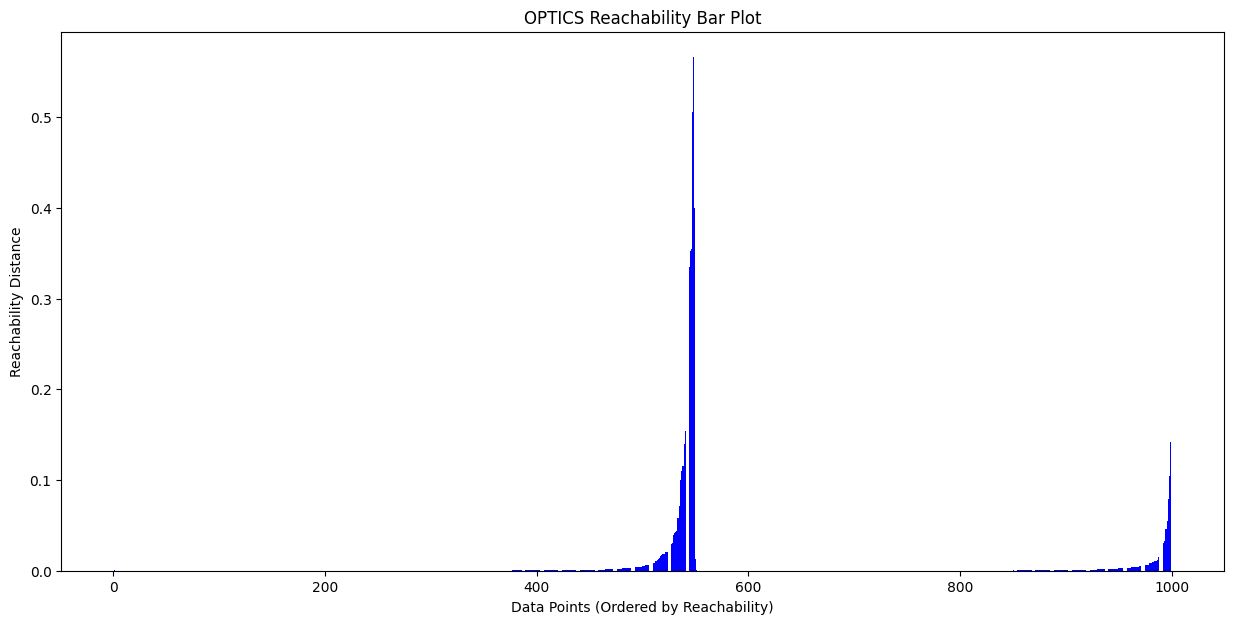

In [ ]:
from sklearn.cluster import OPTICS
optics = OPTICS(min_samples=200, cluster_method = 'dbscan',metric='cosine', eps = 0.52)
optics.fit(all_predictions_array)

# Obtain the reachability distances and cluster labels
reachability_distances = optics.reachability_[optics.ordering_]
cluster_labels = optics.labels_[optics.ordering_]

# Plot the reachability distances as a bar plot
plt.figure(figsize=(15, 7))
plt.bar(range(len(reachability_distances)), reachability_distances, color='blue')
plt.title('OPTICS Reachability Bar Plot')
plt.xlabel('Data Points (Ordered by Reachability)')
plt.ylabel('Reachability Distance')
plt.show()

In [ ]:
def calculate_metrics(true_labels, predicted_labels):
    # Ensure that the arrays have the same shape
    if true_labels.shape != predicted_labels.shape:
        raise ValueError("Arrays must have the same shape")

    # Calculate accuracy
    accuracy = np.sum(true_labels == predicted_labels) / len(true_labels)

    # Calculate precision
    precision = precision_score(true_labels, predicted_labels, average='binary')

    # Calculate recall
    recall = recall_score(true_labels, predicted_labels, average='binary')

    # Calculate F1 score
    f1 = f1_score(true_labels, predicted_labels, average='binary')

    return accuracy, precision, recall, f1

accuracy_optics, precision_optics, recall_optics, f1_optics = calculate_metrics(true_labels, cluster_labels)
print(f"Accuracy: {accuracy_optics * 100:.2f}%")
print(f"Precision: {precision_optics * 100:.2f}%")
print(f"Recall: {recall_optics * 100:.2f}%")
print(f"F1 Score: {f1_optics * 100:.2f}%")


Accuracy: 95.20%
Precision: 100.00%
Recall: 90.40%
F1 Score: 94.96%


#**3. Đánh giá mô hình**

## Đánh giá bằng đường ROC

**Naive Bayes**

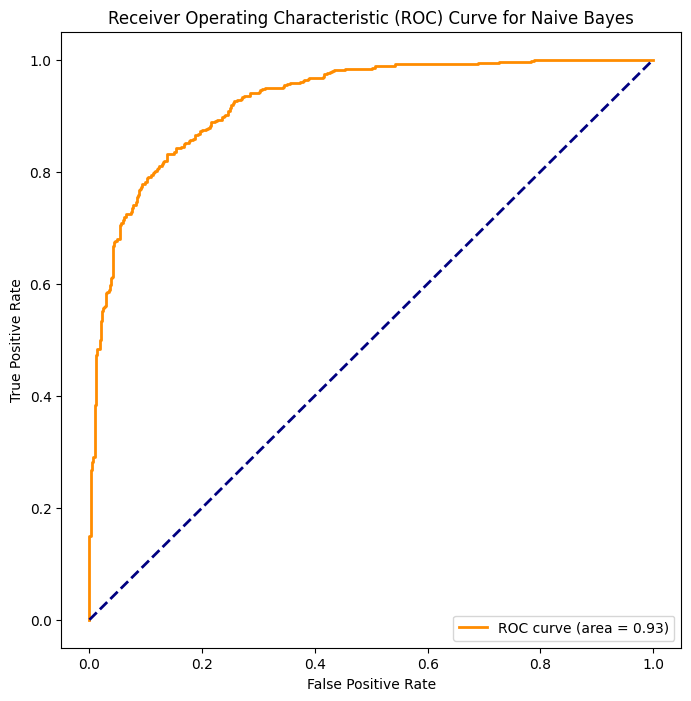

In [ ]:
predicted_probabilities = model_NB.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Vẽ đường ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Naive Bayes')
plt.legend(loc='lower right')
plt.show()

**Logistic Regression**

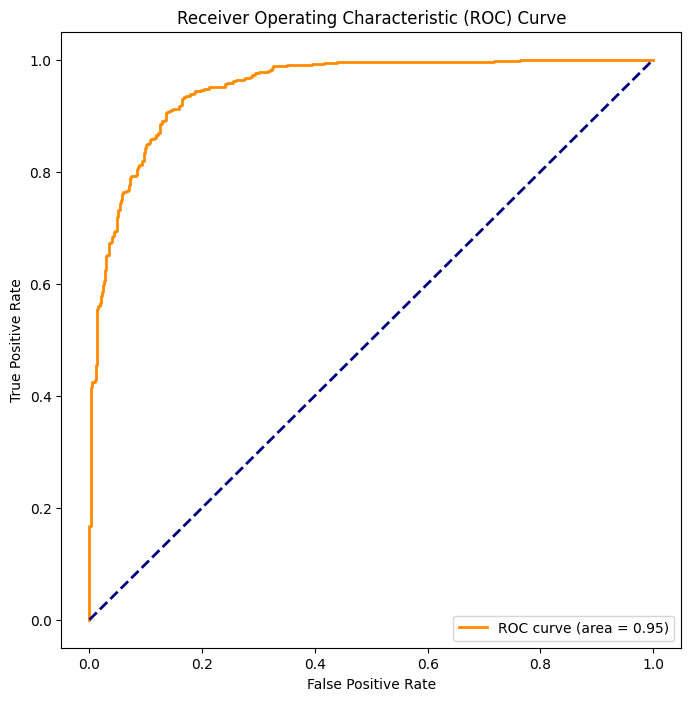

In [ ]:
y_prob = model_LR.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

#Vẽ đường ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**Transformer**

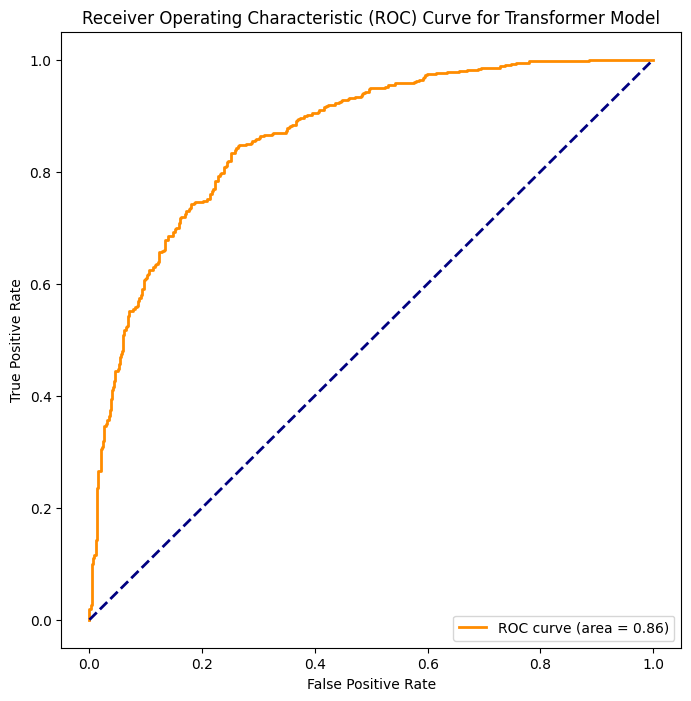

In [ ]:
model_TC.eval()
all_labels = []
all_probabilities = []

with torch.no_grad():
    for idx, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model_TC(inputs)

        probabilities = F.softmax(output, dim=1).numpy()

        all_labels.extend(labels.numpy())
        all_probabilities.extend(probabilities[:, 1])

# Chuyển sang numpy
all_labels = np.array(all_labels)
all_probabilities = np.array(all_probabilities)
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)

# Vẽ đường ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Transformer Model')
plt.legend(loc='lower right')
plt.show()

## Đánh giá bằng confusion matrix

**Naive Bayes**

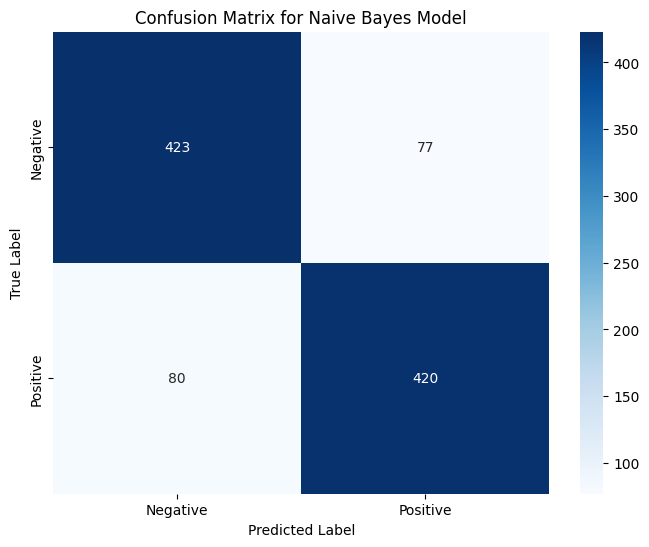

In [ ]:
predicted_probabilities = model_NB.predict_proba(X_test)[:, 1]
predicted_labels = (predicted_probabilities > 0.5).astype(int)

# Tính confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Vẽ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Naive Bayes Model')
plt.show()

**Logistic Regression**

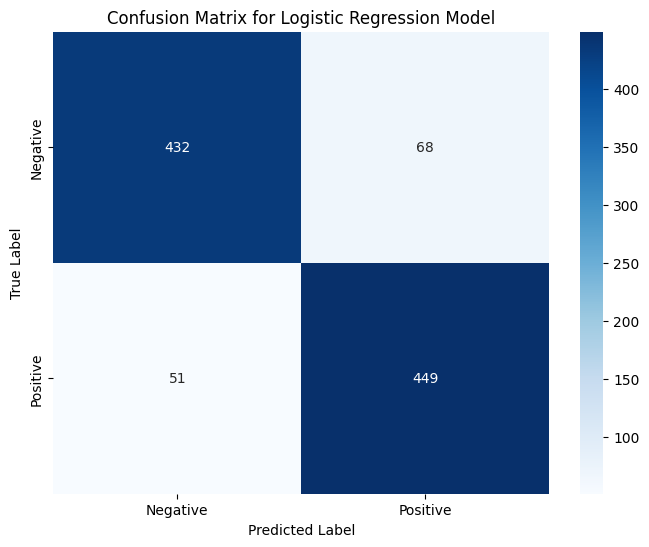

In [ ]:
predicted_probabilities_LR = model_LR.predict_proba(X_test)[:, 1]
predicted_labels_LR = (predicted_probabilities_LR > 0.5).astype(int)

# Tính confusion matrix
conf_matrix_LR = confusion_matrix(y_test, predicted_labels_LR)

# Vẽ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_LR, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

**Transformer**

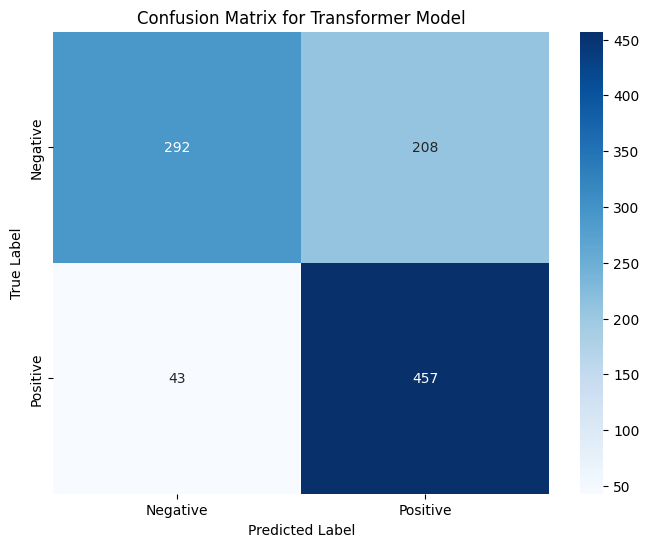

In [ ]:
model_TC.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_TC(inputs)

        predictions = torch.argmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Vẽ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Transformer Model')
plt.show()

## So sánh 3 mô hình

**Tính toán các chỉ số của mô hình NB**

In [ ]:
y_pred = model_NB.predict(X_test)
y_test
metrics_model_NB = [accuracy_score(y_test, y_pred),
                    precision_score(y_test, y_pred),
                    recall_score(y_test, y_pred),
                    f1_score(y_test, y_pred)]

**Tính toán các chỉ số của mô hình LR**

In [ ]:
y_pred = model_LR.predict(X_test)
y_test
metrics_model_LR = [accuracy_score(y_test, y_pred),
                    precision_score(y_test, y_pred),
                    recall_score(y_test, y_pred),
                    f1_score(y_test, y_pred)]

**Tính toán các chỉ số của mô hình Transformer**

In [ ]:
model_TC.eval()

all_labels = []
all_probabilities = []

with torch.no_grad():
    for idx, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model_TC(inputs)

        probabilities = F.softmax(output, dim=1).numpy()

        all_labels.extend(labels.numpy())
        all_probabilities.extend(probabilities[:, 1])

all_labels = np.array(all_labels)
all_probabilities = np.array(all_probabilities)
y_pred = (all_probabilities >= 0.5).astype(int)

# Tính toán các chỉ số của mô hình Transformer
metrics_model_TC = [accuracy_score(all_labels, y_pred),
                    precision_score(all_labels, y_pred),
                    recall_score(all_labels, y_pred),
                    f1_score(all_labels, y_pred)]

In [ ]:
compare_df = pd.DataFrame({
    'Model': ['Model NB', 'Model LR', 'Model TC', 'Model TC (Optics)'],
    'Accuracy': [metrics_model_NB[0], metrics_model_LR[0], metrics_model_TC[0], accuracy_optics],
    'Precision': [metrics_model_NB[1], metrics_model_LR[1], metrics_model_TC[1], precision_optics],
    'Recall': [metrics_model_NB[2], metrics_model_LR[2], metrics_model_TC[2],recall_optics],
    'F1-Score': [metrics_model_NB[3], metrics_model_LR[3], metrics_model_TC[3], f1_optics]
})

# Display
compare_df.groupby('Model').mean().round(2)

,Accuracy,Precision,Recall,F1-Score
Model,,,,
Model LR,0.88,0.87,0.90,0.88
Model NB,0.84,0.85,0.84,0.84
Model TC,0.75,0.69,0.91,0.78
Model TC (Optics),0.95,1.00,0.90,0.95


#**4. Ứng dụng**

In [ ]:
def sentiment_analysis_NB(input):
  input = preprocess_text(input)

  vectorizer = model_NB.named_steps['tfidf']
  nb_classifier = model_NB.named_steps['nb']
  user_input_tfidf = vectorizer.transform([input])
  user_pred = nb_classifier.predict(user_input_tfidf)

  # Display
  if user_pred[0] == 0:
      return 0
  else:
      return 1

In [ ]:
def sentiment_analysis_TC(input):
  input = preprocess_text(input)
  input = vocabulary(tokenizer(input))
  input =  input+([0]* (max_length-len(input))) if len(input) < max_length else x[:max_length]
  input_tensor = torch.tensor(input).unsqueeze(0)
  output = model_TC(input_tensor)
  probabilities = F.softmax(output, dim=0)

  # probabilities is now a tensor representing the probabilities for each class
  #print("Class 0 (negative) probability:", probabilities[0].item())
  #print("Class 1 (positive) probability:", probabilities[1].item())

  if probabilities[0] > probabilities[1]:
    return 0
  else:
    return 1

In [ ]:
def sentiment_analysis_LR(input):
    input = preprocess_text(input)
    vectorizer = model_LR.named_steps['tfidfvectorizer']
    lr_classifier = model_LR.named_steps['logisticregression']
    user_input_tfidf = vectorizer.transform([input])
    user_pred = lr_classifier.predict(user_input_tfidf)

    # Display
    if user_pred[0] == 0:
        return 0
    else:
        return 1


##4.1 Ứng dụng số 1

**Major voting cho final prediction**

In [ ]:
@anvil.server.callable
def final_predict(input):
    pred_1 = sentiment_analysis_NB(input)
    pred_2 = sentiment_analysis_TC(input)
    pred_3 = sentiment_analysis_LR(input)
    count_zeros = sum([pred_1, pred_2, pred_3].count(0) >= 2 for _ in range(3))
    majority_label = 0 if count_zeros >= 2 else 1
    final_prediction = 'negative' if majority_label == 0 else 'positive'

    return final_prediction


In [ ]:
final_predict('Love. Love, Love, Love, Love')

'positive'

In [ ]:
final_predict('Ugh, these XYZ Wireless Earbuds were a major disappointment. The sound quality is just mediocre, and they constantly disconnect, making my listening experience a frustrating mess. I expected better for the price. Definitely regretting this purchase.  ')

'negative'

**Link (dừng hoạt động khi colab dừng hoạt động)**

https://understated-downright-contest.anvil.app

##4.2 Ứng dụng số 2

**Chỉ dùng mỗi Logistic Regression chứ không major voting được như ở trên**

https://huggingface.co/spaces/perman2011/UEH_SentimentAnalysis

#**5. Phần extra (Finetune với mô hình distilbert)**

**Modify từ chính bản gốc của nhóm nghiên cứu tại Google**

**Link tới bản gốc: https://colab.research.google.com/github/DhavalTaunk08/Transformers_scripts/blob/master/Transformers_multilabel_distilbert.ipynb#scrollTo=fb9-Yr9YDZqo**

In [ ]:
# Điều chỉnh các tham số
MAX_LEN = 100
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer_DB = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
train_df_DB = pd.read_csv('/content/data/train.csv')

In [ ]:
train_df_DB

,text,label
0,dare finish book dare finish book simple inter...,0
1,amazon promoting hate stuff like hate jews hom...,0
2,herbie plays easy listening hh great fan disap...,0
3,freddie live 4ever long humans electricity con...,1
4,cord description 100 incorrect new original pa...,0
...,...,...
39429,powdered wax bad idea daughter received one tw...,0
39430,network thinking answer terrific show yanked 4...,1
39431,shave cream product great follow close shave v...,1
39432,zzzzzzzzzzzzzzzzzzzz thought going fall asleep...,0


In [ ]:
train_df_DB['label'] = train_df_DB.iloc[:, 1:].values.tolist()

In [ ]:
test_df_DB = pd.read_csv('/content/data/test.csv')

In [ ]:
test_df_DB = test_df_DB[['text', 'preprocess_sentence', 'label']]

In [ ]:
test_df_DB['label'] = test_df_DB.iloc[:, 2:].values.tolist()

In [ ]:
test_df_DB

,text,preprocess_sentence,label
0,"Man, this is sick stuff!!!!: I set out on a mi...",man sick stuff set mission seek shocking films...,[0]
1,Still waiting for hardware: Ordered (1) chair ...,still waiting hardware ordered 1 chair 1 loves...,[0]
2,"OK Idea, Poorly Executed: Julia was good. Brad...",ok idea poorly executed julia good brad usual ...,[0]
3,Don't bother: This is a total waste of paper. ...,bother total waste paper save forrest print bo...,[0]
4,"Good, but disappointing: This was a good movie...",good disappointing good movie general however ...,[0]
...,...,...,...
995,no problemo: Our school has 100 of the LaCie P...,problemo school 100 lacie p3 xp never problem ...,[1]
996,Thank you Decapitated!: This album ironically ...,thank decapitated album ironically makes hope ...,[1]
997,Super item!: This vest came in handy for a my ...,super item vest came handy son birthday party ...,[1]
998,Great for the price: The car charger works as ...,great price car charger works expected ear bud...,[1]


In [ ]:
class BinaryLabel(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer_DB
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
print("Train dataset: {}".format(train_df_DB.shape))
print("Test dataset: {}".format(test_df_DB.shape))

training_set = BinaryLabel(train_df_DB, tokenizer, MAX_LEN)
testing_set = BinaryLabel(test_df_DB, tokenizer, MAX_LEN)

Train dataset: (39434, 2)
Test dataset: (1000, 3)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model_DB = DistilBERTClass()
model_DB.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = torch.optim.Adam(params =  model_DB.parameters(), lr=LEARNING_RATE)

In [ ]:
#Fine tune 1 epoch rất lâu nếu không có GPU nên nhóm đã finetune trước xong save weight lại, tương tự như mô hình Transformer ở trên
def train(epoch):
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%50==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        if loss.item() < 0.07:
            print(f'Breaking the loop as loss is below 0.07: {loss.item()}')
            break
        loss.backward()
        optimizer.step()

In [ ]:
# https://drive.google.com/file/d/1KVB-uJ07Ez-d8vC7gY2Kw3oXOnmIdJWZ/view?usp=drive_link
!gdown --id 1KVB-uJ07Ez-d8vC7gY2Kw3oXOnmIdJWZ
#for epoch in range(1):
#    train(epoch)

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1KVB-uJ07Ez-d8vC7gY2Kw3oXOnmIdJWZ
To: /content/model_DB_1.pt
100% 268M/268M [00:02<00:00, 104MB/s] 


In [ ]:
# Tải model về để phục vụ cho ném lên huggingfaces spaces
filename = 'model_DB.sav'
joblib.dump(model_DB, filename)

['model_DB.sav']

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loaded_model_path = 'model_DB_1.pt'
model_DB.load_state_dict(torch.load(loaded_model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

In [ ]:
def sentiment_analysis_DB(input):
    inputs = tokenizer.encode_plus(
        input,
        None,
        add_special_tokens=True,
        max_length=100,
        pad_to_max_length=True,
        return_token_type_ids=True
    )
    ids = torch.tensor([inputs['input_ids']])  # Convert to PyTorch tensor
    mask = torch.tensor([inputs['attention_mask']])  # Convert to PyTorch tensor
    token_type_ids = torch.tensor([inputs["token_type_ids"]])  # Convert to PyTorch tensor

    # Assuming model_DB is a PyTorch model
    output = model_DB(ids, mask, token_type_ids)
    #print('Raw output is ', output)

    sigmoid_output = torch.sigmoid(output)
    #print('Sigmoid output is ', sigmoid_output)

    # Assuming you want to use a threshold of 0.5
    result = 1 if sigmoid_output.item() > 0.5 else 0

    if result == 1:
      print('The sentiment is positive')
    else:
      print('The sentiment is negative')



In [ ]:
sentiment_analysis_DB('love')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


The sentiment is positive


In [ ]:
def validation(testing_loader):
    model_DB.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model_DB(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
outputs, targets = validation(testing_loader)
final_outputs = np.array(outputs) >=0.5

y_pred = [item for sublist in final_outputs for item in sublist]
y_true = [item for sublist in targets for item in sublist]

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
250it [03:12,  1.30it/s]


In [ ]:
# Đánh giá mô hình
accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

Accuracy: 0.902
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.91       500
         1.0       0.94      0.86      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



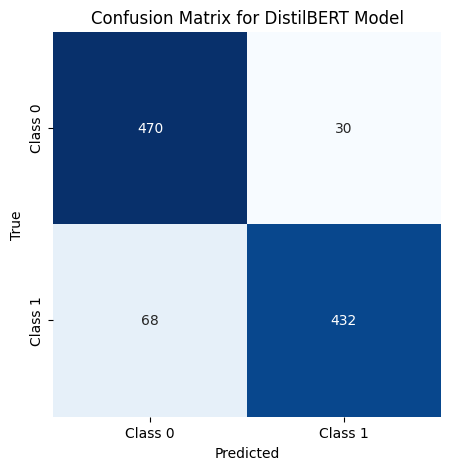

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Vẽ confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for DistilBERT Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
metrics_model_DB = [accuracy_score(y_true, y_pred),
                    precision_score(y_true, y_pred),
                    recall_score(y_true, y_pred),
                    f1_score(y_true, y_pred)]

In [ ]:
# Thêm vào bảng kết quả
compare_df.loc[len(compare_df)] = ['Model DB'] + metrics_model_DB
compare_df.groupby('Model').mean().round(2)

,Accuracy,Precision,Recall,F1-Score
Model,,,,
Model DB,0.90,0.94,0.86,0.90
Model LR,0.88,0.87,0.90,0.88
Model NB,0.84,0.85,0.84,0.84
Model TC,0.75,0.69,0.91,0.78
Model TC (Optics),0.95,1.00,0.90,0.95


In [ ]:
result_df = compare_df.groupby('Model').mean().round(2).sort_values(by='Accuracy', ascending=False)

In [ ]:
result_df

,Accuracy,Precision,Recall,F1-Score
Model,,,,
Model TC (Optics),0.95,1.00,0.90,0.95
Model DB,0.90,0.94,0.86,0.90
Model LR,0.88,0.87,0.90,0.88
Model NB,0.84,0.85,0.84,0.84
Model TC,0.75,0.69,0.91,0.78


In [ ]:
anvil.server.wait_forever()